# BUILD A SIMPLE CRAWLER
# Introduction
## Name:Yuwei Jiang  Class: STAT694


This project aims to create a crawler to scrapy recipe information under country category on www.allrecipes.com  and then export these recipe information in csv form. The packages I used to scrapy recipes and export organized recipe information is 'BeautifulSoup','request','re','time','csv','pandas','random'. After getting these recipes for different countries, the project  identify whether different countries' cusine has the same rate score.



In [ ]:
from bs4 import BeautifulSoup
import requests
import re
import time
import csv
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
import scipy.stats as stats


## Part 1: Create a simple crawler 

### Create def to get content by url and return soup

In [2]:
  
def get_page(url):
    headers= {
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
}
    
    keep_request = True
    while keep_request:
        try:
            response= requests.get(url,headers=headers,timeout=15)
            keep_request = False
            soup=BeautifulSoup(response.text,'lxml')
            return soup
        except:
            print("reconnect")
            time.sleep(1)


### Create def to get all links on the given page(url)
Get links on the given page(page1) and automatically continue to scrapy the next page by using 'for' loop and 'while' loop until all the pages have been searched.

In [3]:
def get_recipe_links(url):
    soup= get_page(url)
    content = soup.find_all( class_="fixed-recipe-card__title-link") 
    links=[x for x in [a.get('href') for a in content]if x is not None]
    return links
def get_all_links(current_page):
    j=1  
    i=1
    links=[]
    for j in range (8):
        j=j+1
        a=get_recipe_links(current_page+'?page='+str(i))
        while  a not in (None,[]):
            links.extend(a)
            print(i)
            i=i+1
            a=get_recipe_links(current_page+'?page='+str(i))
            time.sleep(random.random()*3) 
        print(str(j)+'th try, Total got ' +str(i-1)+' pages and '+ str(len(links))+' links in '+current_page)
    return links

### Create def of a parser to collect information 
The information include author's name, recipe description, overall rate, how many reviews, how many photos, ingredients, how long does it take to cook.

In [4]:
def parser(url):
    soup=get_page(url)
    recipe_name= soup.find('h1')
    try:
        if recipe_name not in (None,[]):
            recipe_name=recipe_name.text.strip()
        else:
            recipe_name='not provided'
    except:
        print('fail to get info')
                               
#author
    author=soup.find('span',class_="submitter__name")
    try:
        if author not in (None,[]):
            author=author.text.strip()
        else:
            author=soup.find('a',class_="author-name link")
            if author not in (None,[]):
                author=author.text.strip()
            else:
                author='not provided'
    except:
        print('fail to get info')
    
#description
    description=soup.find('div',class_="submitter__description")
    try:
        if description not in (None,[]):
            description=description.text.strip()
        else:
            description=soup.find('p',class_='margin-0-auto')
            if description not in (None,[]):
                description=description.text.strip()
            else:
                description='None'
    except:
        print('fail to get info')

#ratestar
    rate=soup.find("div", class_="rating-stars")    
    if rate not in (None,[]):
        rate=re.search("Rated as (.*) out of 5 Stars", str(rate),re.M|re.S|re.I).group(1)
        if rate=='0':
            rate='Unrated'
        else:
            rate=rate
    else:
        rate=soup.find('span',class_="review-star-text")
        if rate not in (None,[]):
            rate=re.search("Rating: (.*) stars",rate.text.strip(),re.M|re.S|re.I)
            if rate not in (None,[]):
                rate=rate.group(1)
            else:
                rate="Unrated"
        else:
            rate='Unrated'

#how many rate
    if rate !='Unrated':
        starate=soup.find_all('div',class_="reviewsummary--bar" )
        if starate not in (None,[]):
            fivestar=re.search('(\d*) cooks loved it!', str(starate), re.M|re.S|re.I).group(1)
            fourstar=re.search('(\d*) cooks liked it!', str(starate), re.M|re.S|re.I).group(1)
            threestar=re.search('(\d*) cooks thought it was Ok', str(starate), re.M|re.S|re.I).group(1)
            twostar=re.search('(\d*) cooks didn\'t like it', str(starate), re.M|re.S|re.I).group(1)
            onestar=re.search('(\d*) cooks couldn\'t eat it', str(starate), re.M|re.S|re.I).group(1)
        else:
            starate=soup.find('ul',class_="ratings-list")
            if starate not in (None,[]):
                fivestar=starate.find_all('span',class_="rating-count")[0].text.strip()
                fourstar=starate.find_all('span',class_="rating-count")[1].text.strip()
                threestar=starate.find_all('span',class_="rating-count")[2].text.strip()
                twostar=starate.find_all('span',class_="rating-count")[3].text.strip()
                onestar=starate.find_all('span',class_="rating-count")[4].text.strip()
            else:
                fivestar="Not provided"
                fourstar="Not provided"
                threestar="Not provided"
                twostar="Not provided"
                onestar="Not provided"
    else:
        fivestar="Unrated"
        fourstar="Unrated"
        threestar="Unrated"
        twostar="Unrated"
        onestar="Unrated"
        
#reviews
    reviews=soup.find('span',class_="review-count")
    if reviews not in (None,[]):
        reviews=re.search("(\d*) review",reviews.text.strip()).group(1)
    else:
        reviews=soup.find("a",class_="ugc-ratings-link ugc-reviews-link")
        if reviews not in (None, []):
            reviews=re.search("(\d*) Review",reviews.text.strip(),re.M|re.S|re.I).group(1)
        else:
            reviews=0

#photos
    photos=soup.find('span',class_="picture-count-link")
    if photos not in (None,[]):
        photos=re.search("(.*) photo",photos.text.strip()).group(1)
    else:
        photos=soup.find("a",class_="ugc-ratings-link ugc-photos-link")
        if photos not in (None, []):
            photos=re.search("(.*) Photo",photos.text.strip(),re.M|re.S|re.I).group(1)
        else:
            photos=0

#ingredients
    ingredients=soup.find_all('span',class_="recipe-ingred_txt added")
    if ingredients  not in (None, []):
        ingredients=[x for x in [a.text.strip() for a in ingredients]]
        ingredients=(','.join(ingredients))
    else:
        ingredients=soup.find('ul',class_="ingredients-section")
        if ingredients not in (None,[]):
            ingredients=soup.find('ul',class_="ingredients-section").find_all('span')
            ingredients=[x for x in [a.text.strip() for a in ingredients]]
            ingredients=(','.join(ingredients))
        else:
            ingredients='Not provided'
    
#readytime
    ready_time=soup.find_all('li',class_="prepTime__item")
    if ready_time not in (None,[]):
        ready_time=re.search('Ready in (.*?)\"',str(ready_time),re.M|re.S|re.I).group(1)   
    else:
        ready_time=soup.find('div', class_="recipe-meta-item-body")
        if ready_time not in (None,[]):
            ready_time=ready_time.text.strip()
        else:
            ready_time='not provided'
        
#nutrition
    calories=soup.find('span',itemprop="calories")
    try:
        if calories not in  (None,[]):
            calories=calories.text.strip()[:-10]
            g_carbs=soup.find('span', itemprop="carbohydrateContent").text.strip()
            g_fat=soup.find('span', itemprop="fatContent").text.strip()
            g_protein=soup.find('span', itemprop="proteinContent").text.strip()
            mg_LDL=soup.find('span', itemprop="cholesterolContent").text.strip()
            mg_sodium=soup.find('span', itemprop="sodiumContent").text.strip()
        else:
            nutrition=soup.find('div',class_="partial recipe-nutrition-section")
            if nutrition not in (None,[]):
                nutrition=nutrition.find('div',class_="section-body").text.strip()
                calories=re.search('(\d*) calories',nutrition,re.M|re.S|re.I).group(1)
                g_carbs=re.search('.*  (.*) g carbohydrates',nutrition,re.M|re.S|re.I).group(1)
                g_fat=re.search('.*  (.*) g total fat',nutrition,re.M|re.S|re.I).group(1)
                g_protein=re.search('.*  (.*) g protein',nutrition,re.M|re.S|re.I).group(1)
                mg_LDL=re.search('.*  (.*) mg cholesterol',nutrition,re.M|re.S|re.I).group(1)
                mg_sodium=re.search('.*  (.*) mg sodium',nutrition,re.M|re.S|re.I).group(1)
            else:
                calories='not provided'
                g_carbs='not provided'
                g_fat='not provided'
                g_protein='not provided'
                mg_LDL='not provided'
                mg_sodium='not provided'
    except:
        print('fail to get info')
        
    info= {
            'recipe':recipe_name,
            'author':author,
            'description':description,
            'rate':rate,
            'fivestar':fivestar,
            'fourstar':fourstar,
            'threestar':threestar,
            'twostar':twostar,
            'onestar':onestar,
            'reviews':reviews,
            'photos':photos,
            'ingredients':ingredients,
            'ready_time':ready_time,
            'calories':calories,
            'g_carbs':g_carbs,
            'g_fat':g_fat,
            'g_protein':g_protein,
            'mg_LDL':mg_LDL,
            'mg_sodium':mg_sodium}
    return info

### Save and read the information that download.
Save links as txt form and open and read links in lists. Writing ricipe information into csv and read csv in pd form. 
 




In [5]:
def save_lists(lists,file_name):
    file=open(file_name+'.txt','w')
    file.write(str(lists))
    file.close()

def read_txt(txt):
    file = open(txt,'r')
    label = [eval(x.strip()) for x in file][0]
    file.close()
    print(label)
def save_csv(df,file_name):
    df.to_csv(path_or_buf = 'C:\\CSUEB\\STAT694\\'+file_name+'.csv')

### Create a crawler

In [5]:
def crawler(url):
    links=[]
    dfs=[]
    soup=get_page(url)
    content=soup.find('div',class_="grid slider").find_all('a')
    for a in content:
        country_link=a.get('href')
        country=re.search('(.*) Recipes',a.find('span',class_="category-title").text.strip()).group(1)
        links=list(set(get_all_links(country_link)))
        #duplicate
        save_lists(links,country)
        n=1
        for link in links:
            temp_dict=parser(link)
            temp_dict['country']=country
            df=pd.DataFrame([temp_dict])
            dfs.append(df)
            n=n+1
            time.sleep(random.random()*2)
        
        final_df = pd.concat(dfs,ignore_index=True)
        final_df = final_df[['recipe','country','author','description','rate','fivestar','fourstar','threestar','twostar',
                         'onestar','reviews','photos','ingredients','ready_time','calories','g_carbs','g_fat','g_protein',
                         'mg_LDL','mg_sodium']] # 调整列顺序
        save_csv(final_df,country)
        print('There are ' + str(n-1)+' unrepeated '+country+ ' recipes in total.')

def crawler_partial(url):
    links=list(set(get_all_links(url)))
        #duplicate
    dfs=[]
    save_lists(links,country)
    n=1
    for link in links:
        temp_dict=parser(link)
        temp_dict['country']=country
        df=pd.DataFrame([temp_dict])
        dfs.append(df)
        n=n+1
        time.sleep(random.random()*2)
    final_df = pd.concat(dfs,ignore_index=True)
    final_df = final_df[['recipe','country','author','description','rate','fivestar','fourstar','threestar','twostar',
                         'onestar','reviews','photos','ingredients','ready_time','calories','g_carbs','g_fat','g_protein',
                         'mg_LDL','mg_sodium']] # 调整列顺序
    save_csv(final_df,country)
    print('There are ' + str(n-1)+' unrepeated '+country+ ' recipes in total')

def get_country(url):
    soup=get_page(url)
    content=soup.find('div',class_="grid slider").find_all('a')
    for a in content:
        country_link=a.get('href')
        country=a.find('span',class_="category-title").text.strip()
        print(country,country_link)

### Scrapy information on allrecipes.com

In [ ]:
%%time
Asian='https://www.allrecipes.com/recipes/227/world-cuisine/asian/?internalSource=hub%20nav&referringId=701&referringContentType=Recipe%20Hub&referringPosition=1&linkName=hub%20nav%20exposed&clickId=hub%20nav%204'
crawler(Asian)
latin_american='https://www.allrecipes.com/recipes/237/world-cuisine/latin-american/?internalSource=hub%20nav&referringId=86&referringContentType=Recipe%20Hub&linkName=hub%20nav%20daughter&clickId=hub%20nav%202'
crawler(latin_american)
European='https://www.allrecipes.com/recipes/231/world-cuisine/european/?internalSource=hub%20nav&referringId=86&referringContentType=Recipe%20Hub&linkName=hub%20nav%20daughter&clickId=hub%20nav%202'
crawler(European)
country='african'
African='https://www.allrecipes.com/recipes/226/world-cuisine/'+country+'/'
crawler_partial(African)
country='lebanese'
lebanese='https://www.allrecipes.com/recipes/1824/world-cuisine/middle-eastern/'+country+'/'
crawler_partial(lebanese)
country='turkish'
turkish='https://www.allrecipes.com/recipes/1825/world-cuisine/middle-eastern/'+country+'/'
crawler_partial(turkish)
country='israeli'
israeli='https://www.allrecipes.com/recipes/1826/world-cuisine/middle-eastern/'+country+'/'
crawler_partial(israeli)
country='australian-and-new-zealander'
AU='https://www.allrecipes.com/recipes/228/world-cuisine/'+country+'/'
crawler_partial(AU)
country='canadian'
CAN='https://www.allrecipes.com/recipes/733/world-cuisine/'+country+'/'
crawler_partial(CAN)
country='us-recipes'
US='https://www.allrecipes.com/recipes/236/'+country+'/'
crawler_partial(US)


reconnect
reconnect
reconnect
reconnect
reconnect
reconnect
reconnect
reconnect


# Part 2: Data Exploratory

### Data Cleaning and Data Exploratory
The raw data scrapy from allrecipes.com has 17704 rows and 20 columns. There's no duplicated recipes and no null objects. 
Here are the numbers of recipes for each country or region.
country
Austrian                          40
Bangladeshi                       17
Belgian                           17
Caribbean                        368
Chinese                          379
Dutch                             50
Eastern European                 495
Filipino                         195
French                           542
German                           372
Greek                            477
Indian                           869
Indonesian                        41
Italian                         2834
Japanese                         267
Korean                           180
Malaysian                         43
Mexican                         2590
Pakistani                         38
Persian                           58
Portuguese                        85
Scandinavian                     234
South American                   285
Spanish                          165
Swiss                             34
Thai                             301
UK and Ireland                   527
Vietnamese                        88
african                          287
australian-and-new-zealander     543
canadian                        1128
israeli                           32
lebanese                          74
turkish                           58
us-recipes                      3991

In [7]:
recipe=pd.read_csv('C:\\CSUEB\\STAT694\\crawler_project\\Allrecipes.csv',encoding = 'unicode_escape')
print(recipe.shape)
recipe.drop_duplicates()
print(recipe.info())



(17704, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17704 entries, 0 to 17703
Data columns (total 20 columns):
recipe         17704 non-null object
country        17704 non-null object
author         17704 non-null object
description    17704 non-null object
rate           17704 non-null object
fivestar       17704 non-null object
fourstar       17704 non-null object
threestar      17704 non-null object
twostar        17704 non-null object
onestar        17704 non-null object
reviews        17565 non-null float64
photos         17704 non-null object
ingredients    17704 non-null object
ready_time     17704 non-null object
calories       17702 non-null object
g_carbs        17704 non-null object
g_fat          17704 non-null object
g_protein      17704 non-null object
mg_LDL         17704 non-null object
mg_sodium      17704 non-null object
dtypes: float64(1), object(19)
memory usage: 2.7+ MB
None


In [8]:
all_rate=recipe[(recipe.rate!='Unrated')& (recipe.fivestar!='Not provided')]
all_rate['rate']=pd.to_numeric(all_rate['rate'], errors='coerce')
all_rate['fivestar']=pd.to_numeric(all_rate['fivestar'], errors='coerce')
all_rate['fourstar']=pd.to_numeric(all_rate['fourstar'], errors='coerce')
all_rate['threestar']=pd.to_numeric(all_rate['threestar'], errors='coerce')
all_rate['twostar']=pd.to_numeric(all_rate['twostar'], errors='coerce')
all_rate['onestar']=pd.to_numeric(all_rate['onestar'], errors='coerce')
all_rate.agg({'rate':['count','mean','min','max','median','std']})



C:\Users\Vivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Vivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Vivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,rate
count,11437.000000
mean,4.330028
min,1.000000
max,5.000000
median,4.420000
std,0.380259


The following country has more than 400 recipes:'Indian','Italian','Mexican','australian-and-new-zealander','canadian','us-recipes'. A ANOVA test is applied to see if there's any difference in rating scores between these countries.

In [9]:

summary=all_rate.groupby('country',as_index=False ).agg({'rate':['count','mean','min','max','median','std']})
print(summary)
print(list(summary.columns))
print(summary[summary[('rate', 'count')]>400 ])


                         country  rate                                       
                                 count      mean   min   max median       std
0                       Austrian    27  4.282593  2.94  4.75  4.410  0.407616
1                    Bangladeshi     8  4.232500  3.33  4.58  4.370  0.417706
2                        Belgian    11  4.303636  3.78  4.71  4.500  0.340361
3                      Caribbean   219  4.299178  2.67  4.90  4.380  0.412306
4                        Chinese   248  4.254556  2.50  5.00  4.330  0.371514
5                          Dutch    23  4.234348  2.22  4.72  4.370  0.564373
6               Eastern European   286  4.283112  1.00  5.00  4.375  0.427507
7                       Filipino    93  4.246774  2.92  5.00  4.320  0.411535
8                         French   370  4.376054  1.80  5.00  4.450  0.383872
9                         German   219  4.276621  2.37  4.88  4.380  0.408761
10                         Greek   339  4.352920  3.00  5.00  4.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8040 entries, 1113 to 17703
Data columns (total 20 columns):
recipe         8040 non-null object
country        8040 non-null object
author         8040 non-null object
description    8040 non-null object
rate           8040 non-null float64
fivestar       8040 non-null int64
fourstar       8040 non-null int64
threestar      8040 non-null int64
twostar        8040 non-null int64
onestar        8040 non-null int64
reviews        7921 non-null float64
photos         8040 non-null object
ingredients    8040 non-null object
ready_time     8040 non-null object
calories       8039 non-null object
g_carbs        8040 non-null object
g_fat          8040 non-null object
g_protein      8040 non-null object
mg_LDL         8040 non-null object
mg_sodium      8040 non-null object
dtypes: float64(2), int64(5), object(13)
memory usage: 1.3+ MB
None


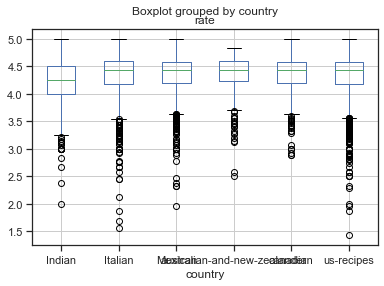

In [10]:
test=all_rate[all_rate['country'].isin (['Indian','Italian','Mexican',
    'australian-and-new-zealander','canadian','us-recipes'])]
print(test.info())
test.boxplot('rate',by='country')

# Part3: ANOVA TEST
    - Is there any difference in rating between following countries:'Indian','Italian','Mexican','australian-and-new-zealander','canadian','us-recipes'?


## Model Fitting
Two different methods to conduct ANOVA TEST in python. One uses statsmodels package. One uses pingouin package.
 - import statsmodels.api as sm
 - from statsmodels.formula.api import ols
 - import pingouin as pg

In [11]:
mod=ols('rate ~ country',data=test).fit()
aov_table=sm.stats.anova_lm(mod,typ=1)
print(aov_table)


              df       sum_sq   mean_sq          F        PR(>F)
country      5.0     9.769447  1.953889  15.035465  1.003804e-14
Residual  8034.0  1044.034700  0.129952        NaN           NaN


In [12]:
aov = pg.anova(data=test, dv='rate', between='country', detailed=True)
print(aov)

    Source        SS    DF     MS       F       p-unc    np2
0  country     9.769     5  1.954  15.035  1.0038e-14  0.009
1   Within  1044.035  8034  0.130       -           -      -


In [14]:


pt = pg.pairwise_tukey(dv='rate', between='country', data=test)

print(pt[pt['p-tukey'] <=0.05])
pair_t = mod.t_test_pairwise('country')
pair_result=pair_t.result_frame
pair_result.info()
pair_result[pair_result['pvalue-hs']*15*14/2 <=0.05]

        A                             B   mean(A)   mean(B)      diff     SE  \
0  Indian                       Italian  4.202197  4.347556 -0.145360  0.019   
1  Indian                       Mexican  4.202197  4.355685 -0.153488  0.019   
2  Indian  australian-and-new-zealander  4.202197  4.377081 -0.174884  0.024   
3  Indian                      canadian  4.202197  4.357749 -0.155552  0.023   
4  Indian                    us-recipes  4.202197  4.349765 -0.147568  0.018   

        tail      T  p-tukey  efsize  eftype  
0  two-sided -7.618    0.001  -0.403  hedges  
1  two-sided -7.916    0.001  -0.426  hedges  
2  two-sided -7.347    0.001  -0.485  hedges  
3  two-sided -6.793    0.001  -0.431  hedges  
4  two-sided -7.983    0.001  -0.409  hedges  
<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, Italian-Indian to us-recipes-canadian
Data columns (total 8 columns):
coef               15 non-null float64
std err            15 non-null float64
t                  15 non-null f

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Italian-Indian,0.145360,0.019077,7.619467,2.837633e-14,0.107963,0.182756,3.694822e-13,True
Mexican-Indian,0.153488,0.019386,7.917663,2.743826e-15,0.115487,0.191489,3.885781e-14,True
australian-and-new-zealander-Indian,0.174884,0.023800,7.348163,2.206762e-13,0.128230,0.221538,2.648548e-12,True
canadian-Indian,0.155552,0.022895,6.794243,1.166483e-11,0.110672,0.200431,1.283126e-10,True
us-recipes-Indian,0.147568,0.018483,7.984200,1.610261e-15,0.111338,0.183799,2.498002e-14,True


## Assumption Check
### Homogeneity of Variance

In [70]:
stats.levene(test['rate'][test['country'] == 'Indian'],
             test['rate'][test['country'] == 'Italian'],
             test['rate'][test['country'] == 'Mexican'],
            test['rate'][test['country'] == 'australian-and-new-zealander'],
            test['rate'][test['country'] == 'canadian'],
            test['rate'][test['country'] == 'us-recipes'])

LeveneResult(statistic=8.986531394565066, pvalue=1.5814892426353427e-08)

In [72]:
stats.shapiro(mod.resid)

(0.8864009380340576, 0.0)

### Conclusion: 
Since the p-value 

0.32718370201976044 0.17994229255923755 0.11314155810090058 0.09250677625251377 0.06426510448544198 0.06146716796362683 0.05718282766459736 0.05455976217539565 0.049750808778525835


C:\Users\Vivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


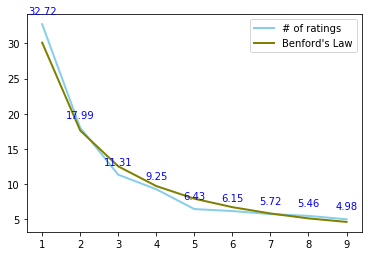

In [10]:
all_rate['n_rate']=all_rate.fivestar+all_rate.fourstar+all_rate.threestar+all_rate.twostar+all_rate.onestar
d_1=0
d_2=0
d_3=0
d_4=0
d_5=0
d_6=0
d_7=0
d_8=0
d_9=0

for x in all_rate.loc[:,'n_rate']:
    if str(x)[0]=='1':
        d_1=d_1+1
    if str(x)[0]=='2':
        d_2=d_2+1
    if str(x)[0]=='3':
        d_3=d_3+1
    if str(x)[0]=='4':
        d_4=d_4+1
    if str(x)[0]=='5':
        d_5=d_5+1
    if str(x)[0]=='6':
        d_6=d_6+1
    if str(x)[0]=='7':
        d_7=d_7+1
    if str(x)[0]=='8':
        d_8=d_8+1
    if str(x)[0]=='9':
        d_9=d_9+1
print(d_1/11437,d_2/11437,d_3/11437,d_4/11437,d_5/11437,d_6/11437,d_7/11437,d_8/11437,d_9/11437)
    

y1 = [d_1/11437*100,d_2/11437*100,d_3/11437*100,d_4/11437*100,d_5/11437*100,d_6/11437*100,d_7/11437*100,d_8/11437*100,d_9/11437*100]
x=[1,2,3,4,5,6,7,8,9]
y2=[30.1,17.6,12.5,9.7,7.9,6.7,5.8,5.1,4.6]

plt.plot(x, y1,markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2,label='# of ratings')
plt.plot( x, y2, marker='', color='olive', linewidth=2,label="Benford's Law")

for x,y in zip(x,y1):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',color='blue') # horizontal alignment can be left, right or center



plt.legend()



